# 0.0 Imports 

In [1]:
import math
import numpy             as np
import pandas            as pd
import random
import pickle
import warnings
import inflection
import seaborn           as sns
import xgboost           as xgb
import datetime
import matplotlib.pyplot as plt
import seaborn           as sns
import os


from matplotlib.gridspec   import GridSpec
from scipy                 import stats       as ss
from boruta                import BorutaPy
from matplotlib            import pyplot      as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Funções auxiliares


In [2]:
# Funcção cross_validation:
#Divide os dados em pedaços de treino (para ensinar o modelo) e validação (para testar).
#Repete o processo várias vezes (kfold) mudando os pedaços.
#No final, calcula a média dos erros para ter uma visão justa de como o modelo se sai.

#Etapas dentro da função:
# 1 Separa datas de treino e validação (como treinar com dados antigos e prever semanas futuras).
# 2 Remove colunas que não servem para prever (date, sales).
# 3 Treina o modelo (fit).
# 4 Faz previsões (predict).
# 5 Calcula os erros com a função ml_error.
# 6 Guarda os erros de cada rodada.
# 7 No fim, retorna um resumo com média e desvio padrão dos erros.          

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # armazenar o desempenho de cada iteração kfold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

# O modelo de vendas nunca vai acertar 100%. Então medimos o quanto ele erra:
# mean_percentage_error: mede o erro em porcentagem (pode ser negativo).
# mean_absolute_percentage_error: mede o erro em porcentagem mas sem sinal (só a distância entre o valor real e o previsto).
# ml_error: calcula três métricas principais:
# MAE (Mean Absolute Error): erro médio absoluto.
# MAPE (Mean Absolute Percentage Error): erro médio percentual.
# RMSE (Root Mean Squared Error): penaliza mais os erros grandes

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse }, index=[0] )
    
#Serve para ver se duas variáveis categóricas (ex: tipo de loja, feriado, dia da semana) estão relacionadas.
#Se der perto de 0, significa que as variáveis não têm relação.
#Se der perto de 1, significa que estão muito relacionadas.
#Isso ajuda na etapa de entendimento dos dados do CRISP-DM: saber quais variáveis fazem sentido para prever as vendas.
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()    
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

## 0.2 Carregando dados


In [3]:
# carregando os dados
df_sales_raw = pd.read_csv(r"C:\Users\Felipe\Documents\Repos\DS\train.csv", low_memory=False)
df_store_raw = pd.read_csv(r"C:\Users\Felipe\Documents\Repos\DS\store.csv", low_memory=False)

#Juntando as duas tabelas pela coluna store com todas as linhas
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos dados 

In [4]:
df1 = df_raw

## 1.1 Renomenado Colunas

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
             'Promo2SinceYear', 'PromoInterval']
#Aqui está sendo criada uma função anônima (com lambda).
#Essa função recebe um texto (x) e aplica inflection.underscore(x).
#A biblioteca inflection transforma CamelCase em snake_case
snakecase = lambda x: inflection.underscore(x)

#Aplicando a função em toda a lista
cols_new=  list(map(snakecase, cols_old)) 

# rename
df1.columns = cols_new

## 1.2 Dimensões de dados


In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print(f'Number of Cols: {(df1.shape[1])}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Tipos de dados


In [7]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Checando  NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preenchendo os NA

In [9]:
#Esse trecho é sobre tratamento de dados faltantes e criação de variáveis novas


#competition_distance
#Problema: tem valores faltantes (NaN)
#Solução: quando o valor está faltando, ele coloca 200.000 metros (200 km) → que é como dizer “não tem concorrente perto”
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else (x))

#competition_open_since_month     
#Se o dado estiver faltando, o código substitui pelo mês da data atual (da linha).
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year      
#Se o dado estiver faltando, assume o ano da data atual.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week      
#Se estiver faltando, assume a semana da data atual
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year       
#Se estiver faltando, assume o ano da data atual.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval   
#Mapeando números de meses para nomes (criando dicionario)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#Se não tiver informação, substitui por 0 (significa “sem promoção”).
df1['promo_interval'].fillna(0, inplace=True)

#Pega o número do mês de cada linha (ex: 7) e traduz para o nome do mês (Jul).
df1['month_map'] = df1['date'].dt.month.map(month_map)

#Se promo_interval == 0 → não tem promoção, então is_promo = 0.
#Se o mês da venda (month_map) está dentro dos meses de promoção (promo_interval) → is_promo = 1.Caso contrário → is_promo = 0.
#1 → loja está em promoção no mês da data.
#0 → loja não está em promoção.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x ['month_map'] in x['promo_interval'].split(',') else 0, axis= 1) 

## 1.6 Tipos de alteração


In [10]:
# Alterando o tipo das colunas para inteiro 

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7 Estatística descritiva


In [11]:
#Selecionando atributos numéricos
num_attributes = df1.select_dtypes(include=['int64','int32', 'float64'])
#Selecionando atributos categóricos
cat_attributes = df1.select_dtypes(exclude=['int64','int32', 'float64', 'datetime64[ns]'])                                 

## 1.7.1 Atributos Numéricos


In [12]:
# Tendência central = média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão  = std, min, max, range, skew, kurtosis
d1 =  pd.DataFrame(num_attributes.apply(np.std)).T
d2 =  pd.DataFrame(num_attributes.apply(min)).T
d3 =  pd.DataFrame(num_attributes.apply(max)).T
d4 =  pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 =  pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 =  pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# Juntando 
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

## 1.7.2 Categorical Attributes 

In [13]:
# quantidade de cada categoria
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

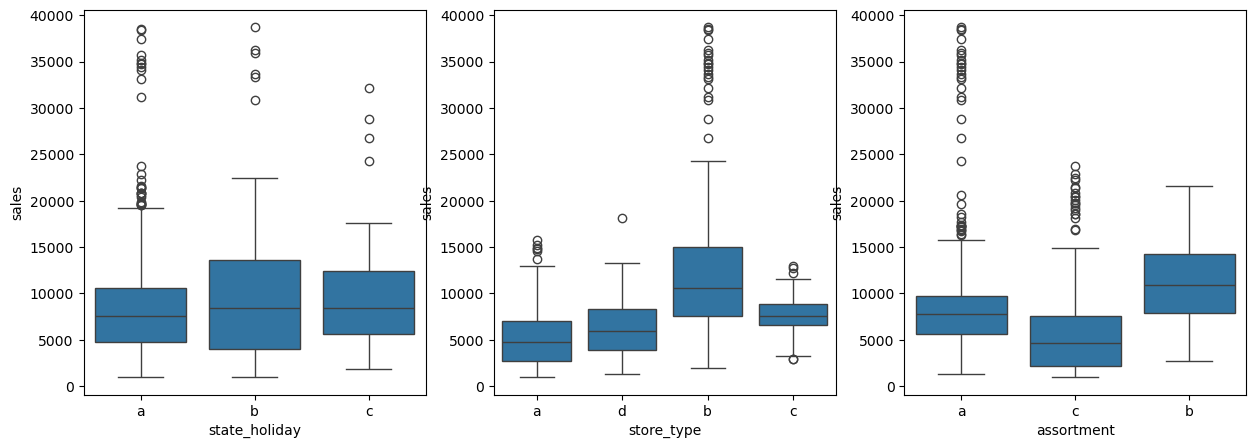

In [14]:
# comparando a distribuição de vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 5))

# desenhando um boxplot mostrando como as vendas (sales) se distribuem para cada tipo de feriado (state_holiday).
plt.subplot(1, 3, 1)
sns.boxplot( x= 'state_holiday', y='sales', data= aux1)  
# vendas por tipo de loja (store_type)
plt.subplot(1, 3, 2)
sns.boxplot( x= 'store_type', y='sales', data= aux1)  
# vendas por tipo de sortimento de produtos (assortment).
plt.subplot(1, 3, 3)            
sns.boxplot( x= 'assortment', y='sales', data= aux1)  


#Interpretação
# 1 grafico =  Em feriados, existe uma dispersão grande nas vendas, mas a tendência central não muda tanto entre feriados diferentes
# 2 grafico =  o tipo de loja influencia bastante as vendas, sendo o tipo b claramente mais lucrativo
# 3 grafico =  o tipo de sortimento afeta as vendas, e o tipo b parece ser o mais vantajoso em média.

# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipoteses 

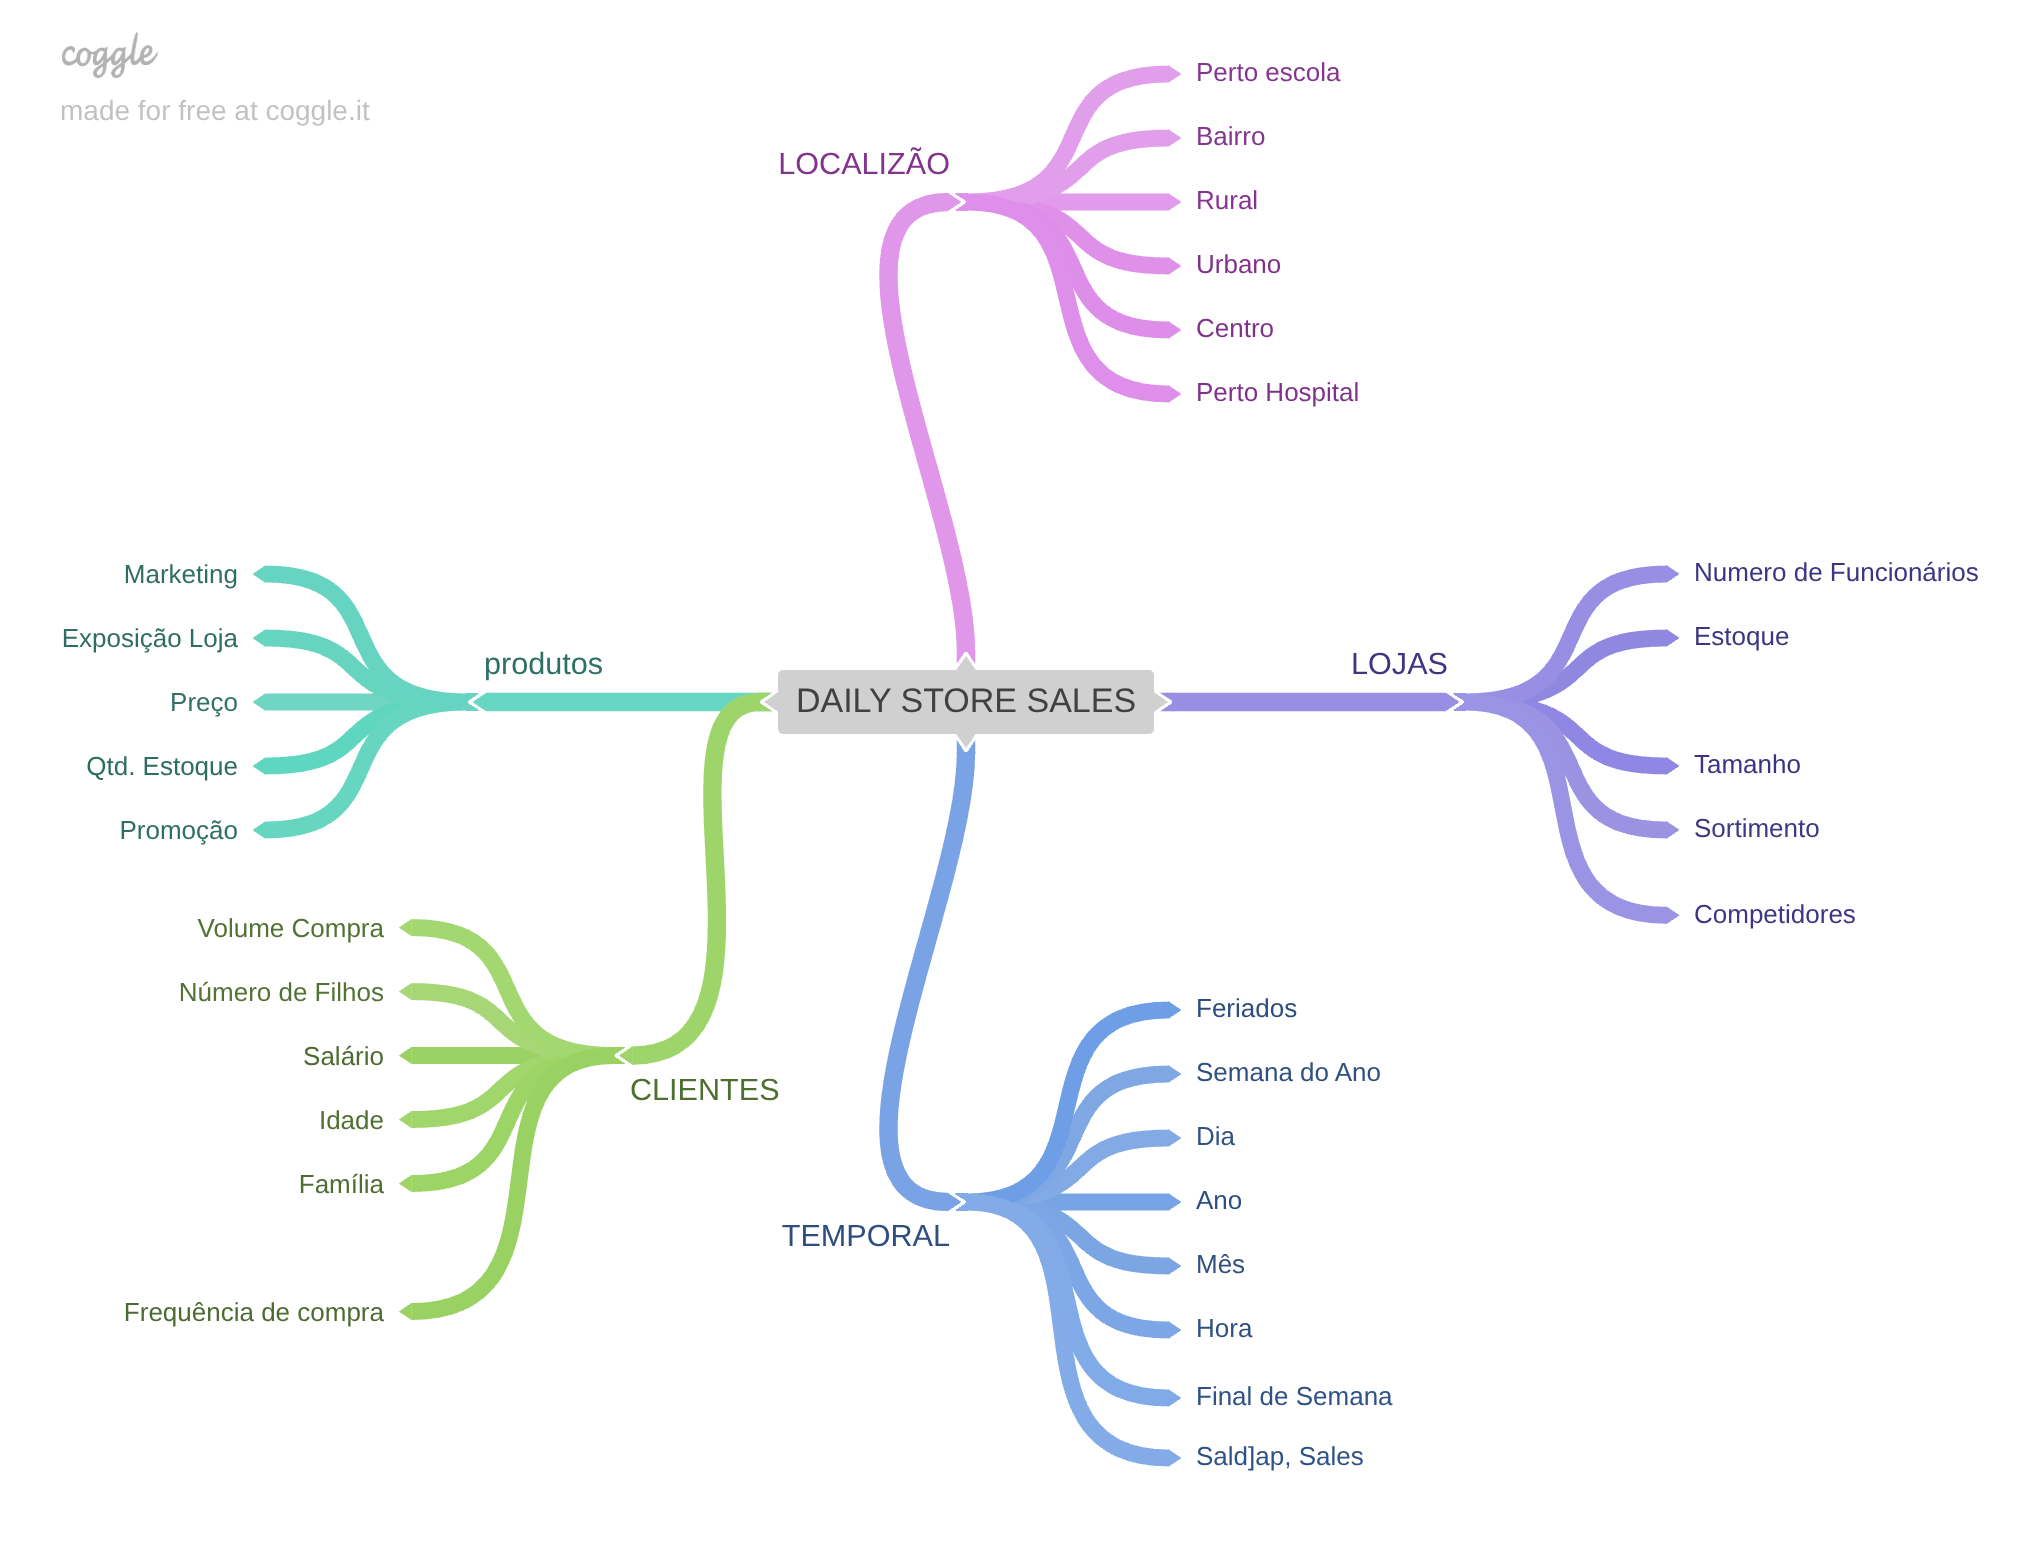

In [16]:
Image(r"C:\Users\Felipe\Documents\Repos\DS\MindMapHypothesis.png")


## 2.2 Criação das Hipóteses

### 2.2.1 Hipótese Loja

**1.**  Lojas com maior quadro de funcionáiros deveriam vender mais.

**2.**  Lojas com maior estoque deveriam vender mais.

**3.**  Lojas com maior porte deveriam vender mais.

**4.**  Lojas com competidores mais próximos deveriam vender menos

**5.**  Lojas com mais soritmento deveriam vender mais.  

**6.**  Lojas com competidores à mais tempo deveriam vendem mais.  

### 2.2.2 Hipótese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto na vitrine deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipótese Temporal 

**1.**  Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4  Lista Final de Hipóteses


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.    

## 2.3 Features Engineering

In [17]:
# separando o ano
df2['year'] = df2['date'].dt.year

# separando o mes
df2['month'] = df2['date'].dt.month

# separando o dia
df2['day'] = df2['date'].dt.day

# separando a senaba do ano 
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# identificador como "2015-23" (ano + semana).
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# criando uma data de início da concorrência usando as colunas de ano e mês.Sempre fixa o dia = 1, já que não temos a informação do dia exato.
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

# Calcula quantos meses a concorrência já existe na data da venda. subtraindo a data da venda (date) da data de início da concorrência (competition_since).
df2['competition_time_month'] = ( ( df2['date']- df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# Cria uma string juntando ano e semana da promoção. Exemplo: "2015-13
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

# Converti essa string em uma data real, considerando o início da semana. O + datetime.timedelta(days=7) ajusta para pegar corretamente a data da promoção.
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') + datetime.timedelta(days=7))

#Calculando há quantas semanas a loja está em promoção na data da venda.
df2['promo_time_week'] = ( ( df2['date']- df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
                                                                                                    
# traduzindo as váriaves categóricas 
# Traduz o sortimento de produtos:
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
#Traduz feriados:
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')                                                                                                     
                                                                                                    

# 3.0 Filtragem de váriaveis 

In [18]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [19]:
# removendo dados irrelevantes (loja fechada ou vendas zeradas) 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem das colunas 

In [20]:
# removendo colunas 
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Análise Exploratória dos dados 

In [21]:
df4 = df3.copy()

## 4.1. Analise Univariada

C:\Users\Felipe\AppData\Local\Temp\ipykernel_1628\1689225702.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=True, hist=True)


<Axes: xlabel='sales', ylabel='Density'>

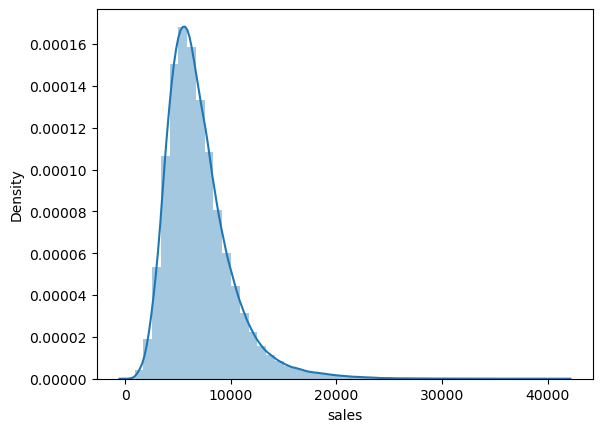

In [22]:
sns.distplot(df4['sales'], kde=True, hist=True)
# Distribuição não é simétrica
# A maior parte das lojas vende até 10.000 unidades.
# Moda (pico da curva) → está em torno de 5.000–7.000 vendas, ou seja, é o valor mais comum.
#Cauda longa à direita → indica que existem poucos casos com vendas bem maiores que a média.

### 4.1.1 Response Variable 

In [23]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


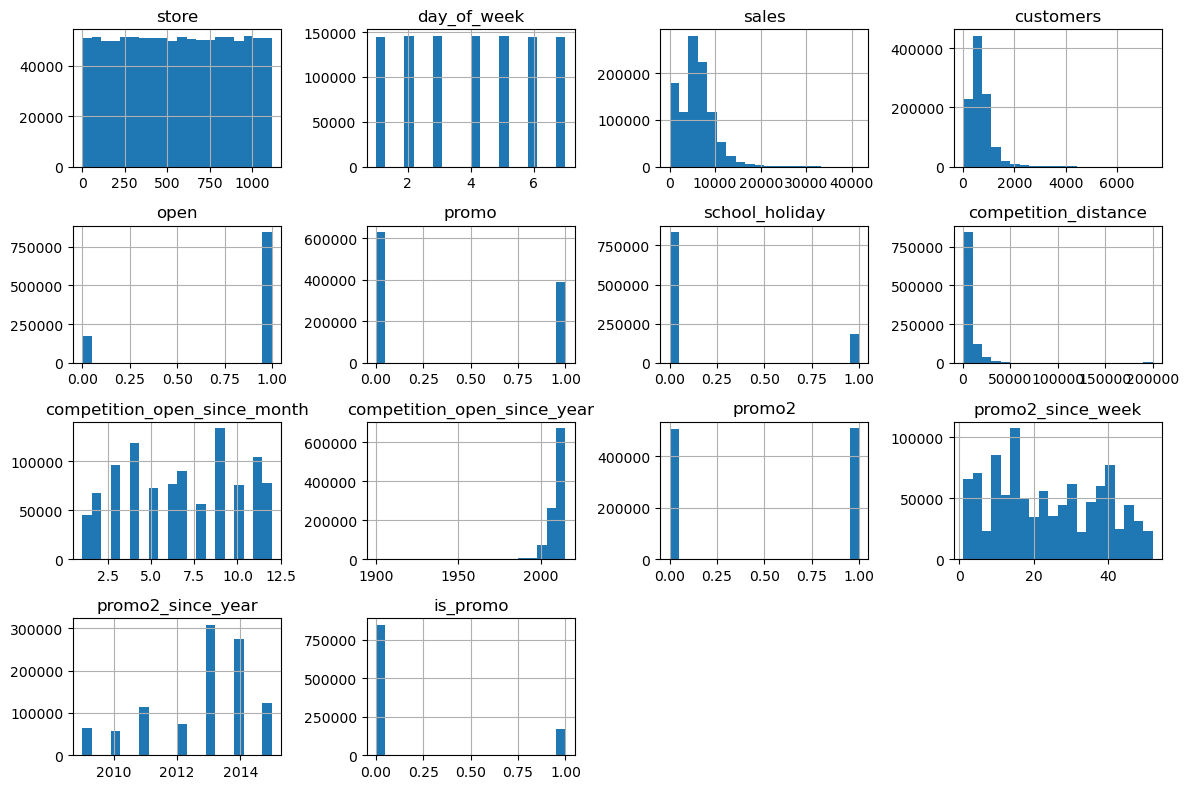

In [24]:
num_attributes.hist(figsize=(12, 8), bins=20)
plt.tight_layout()


Avaliação:

**Competition distance:** A maioria das lojas os concorrentes estão próximos do zero, poucos tem concorentes distantes

**competition_open_since_month:** Concorrentes abriram lojas em diferents meses, sem concentração

**competition_open_since_year:** A concorrência começou a crescer  partir dos anos 2000, quase não tinha nos anos 80

**customers:** Distribuição concentrada entre 0 e 2000, poucas lojas ultrapassam 

**day_of_week:** Os valores aparecem de forma equilibrada todos os dias da semana

**open:** váriavel quase binária, 1 a loja está aberta

**promo:** Também binária (0 = sem promoção, 1 = com promoção).Mais registros em 0, mas bastante em 1.Promoções não são tão raras.

**promo2:** Muitas lojas não participam (0).Também binária.Apenas parte das lojas tem promoções contínuas.

**promo2_since_week:** Valores espalhados de 1 até ~50.Promoções começaram em diferentes semanas do ano.

**promo2_since_year**: Picos entre 2013 e 2014.

**sales:** Distribuição concentrada entre 0 e 10.000 vendas.

**school_holiday:** Binária (0 = não é feriado escolar, 1 = feriado escolar)

**store:** Quase uniforme de 1 até o número máximo de lojas (~1000). Representação equilibrada de cada loja no dataset.

### 4.1.2 Categorical Variable 

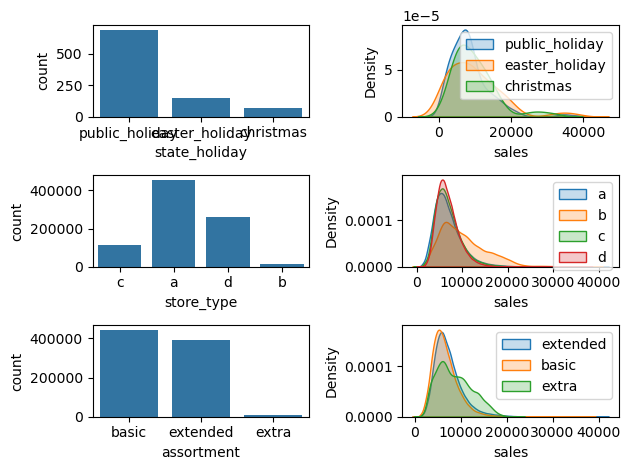

In [25]:
# Quantas ocorrências de cada tipo de feriado (público, páscoa, natal) existem no dataset
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=a)

#distribuição de vendas em cada tipo de feriado (curvas de densidade → onde as vendas são mais concentradas).
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()

# quantas lojas existem de cada tipo (a, b, c, d)
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

# como as vendas variam em cada tipo de loja (lojas do tipo "b" vendem mais? "a" vende menos?
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()

# quantas lojas têm cada tipo de sortimento (básico, extra, estendido).
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

# distribuição de vendas por tipo de sortimento (quem tem sortimento "extended" tende a vender mais?).
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()

# Ajusta os espaços
plt.tight_layout()
plt.show()


## 4.2 Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.


<Axes: xlabel='year_week'>

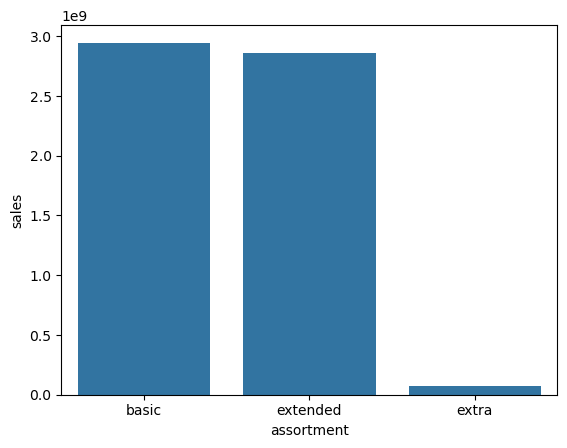

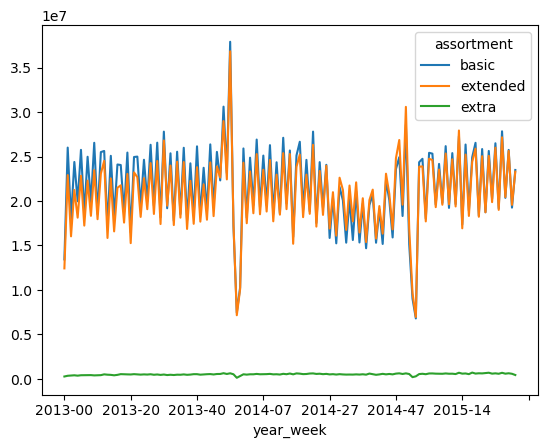

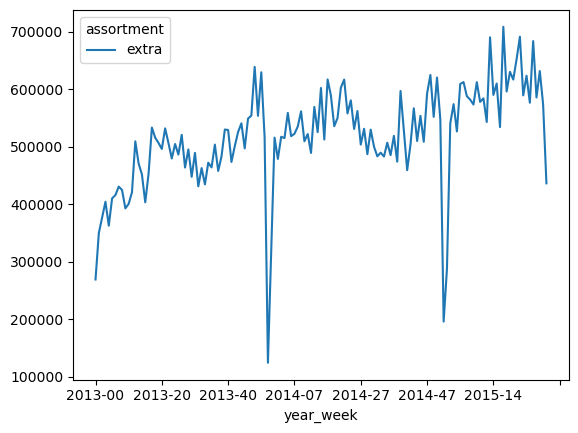

In [26]:
 aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
 sns.barplot( x='assortment', y='sales', data=aux1 );

 aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
 aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

 aux3 = aux2[aux2['assortment'] == 'extra']
 aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.


C:\Users\Felipe\AppData\Local\Temp\ipykernel_1628\234979630.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot=True)


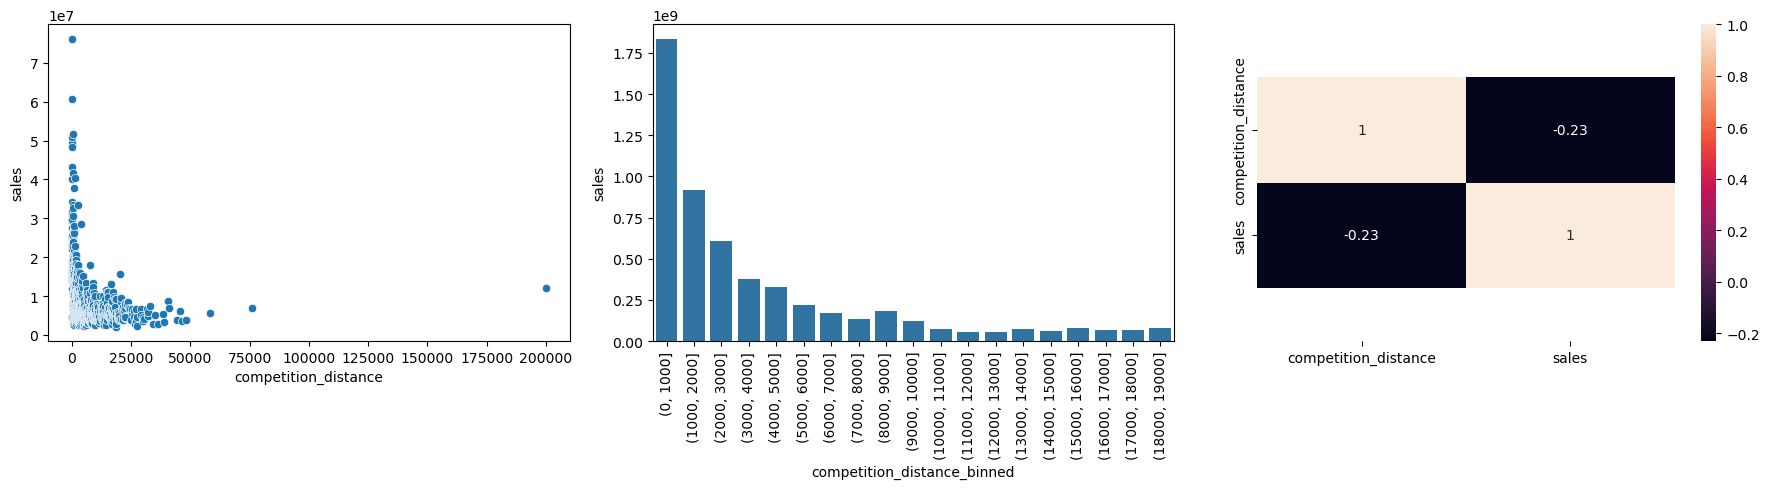

In [27]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(18, 5))  # aumenta o espaço da figura

# Scatterplot
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# Barplot com bins
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

# Heatmap
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()  # evita sobreposição
plt.show()

# Concentração de vendas estão nos vendedores mais próximas, a correlação de -0,23 é baixa

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSO** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.


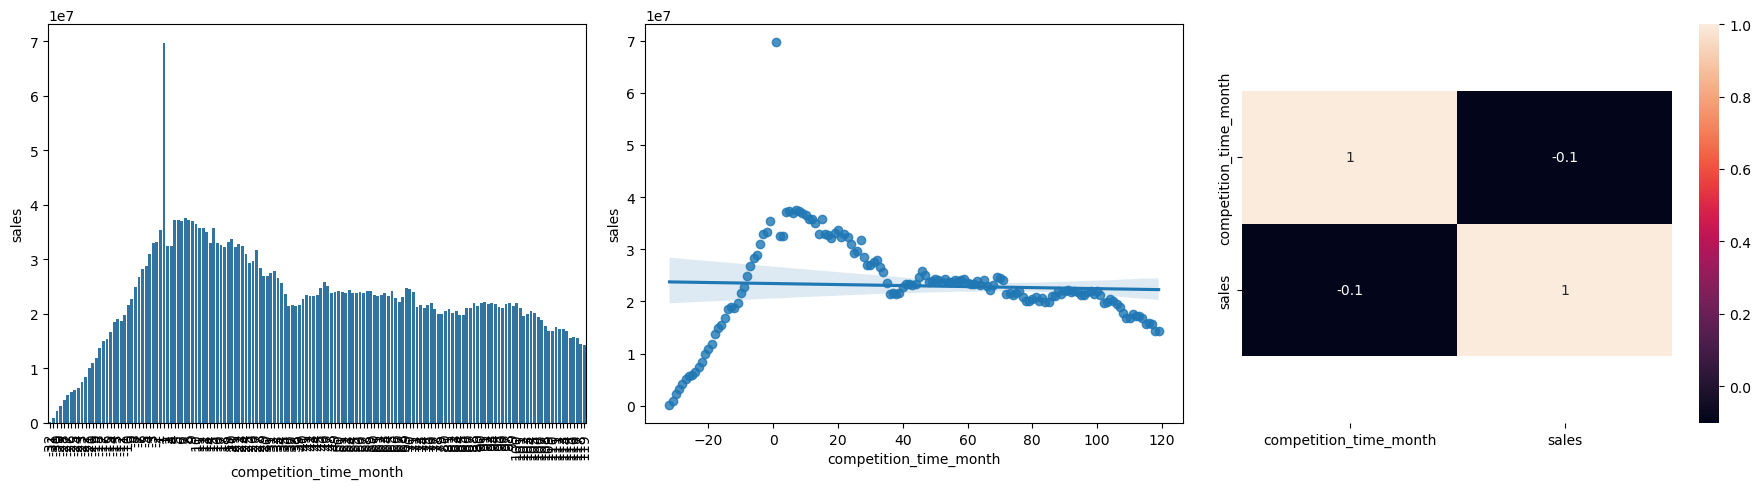

In [28]:
plt.figure(figsize=(18, 5))  

# Barplot
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

# Regressão
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# Heatmap
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()   
plt.show()


# quanto mais rececente a competição, maior é a venda

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo  de promocao

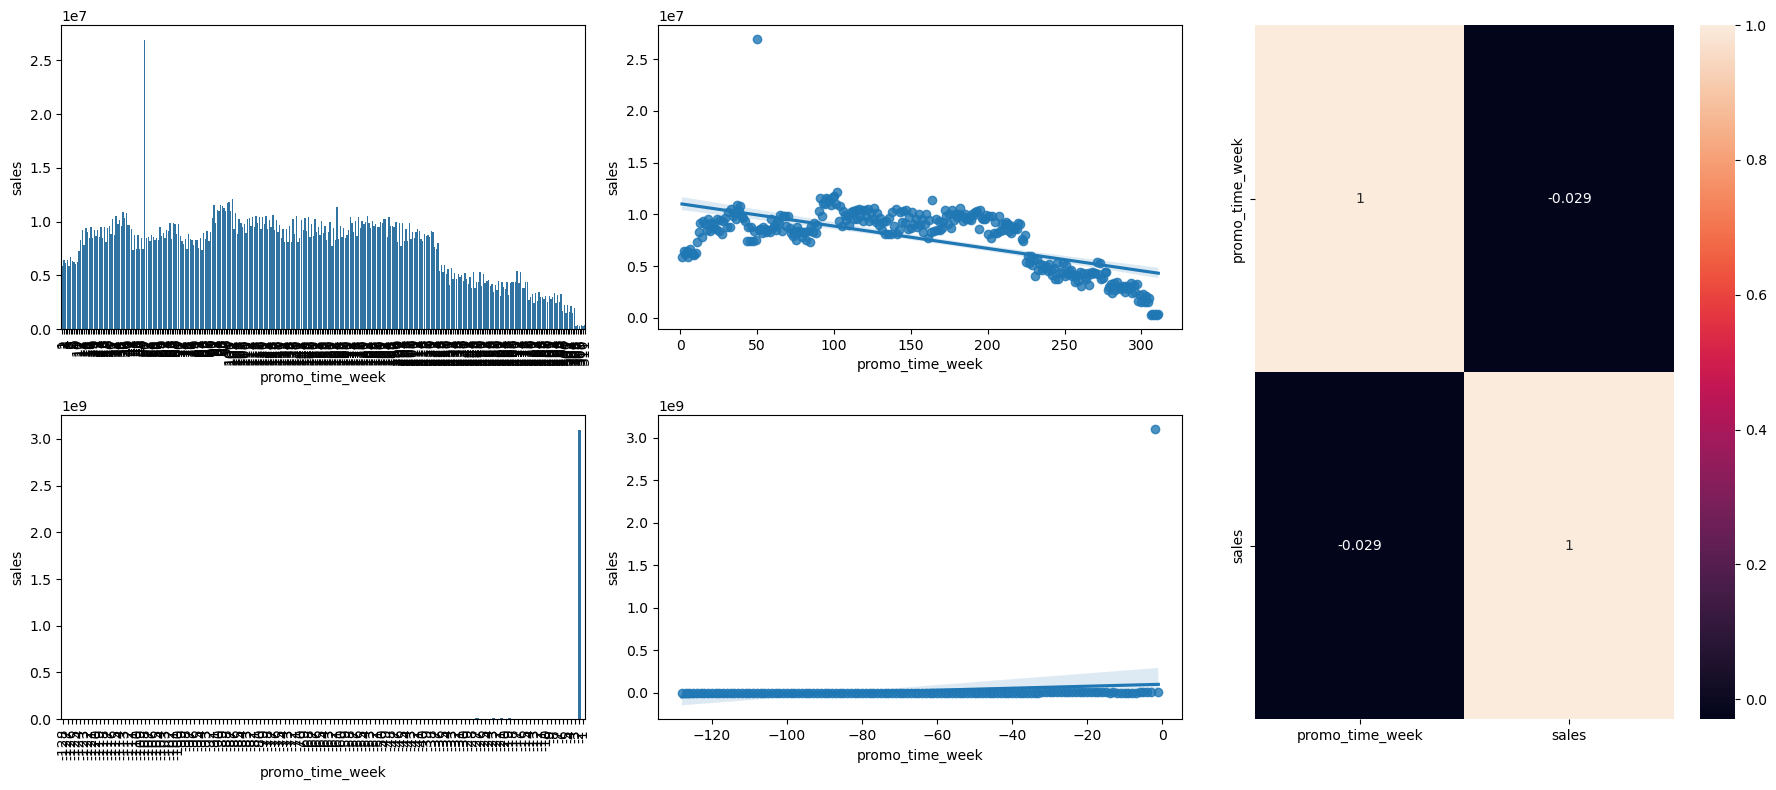

In [29]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(18, 8))  # aumenta espaço para os 5 gráficos
grid = GridSpec(2, 3)

# Promo extendido - barplot
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

# Promo extendido - regressão
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

# Promo regular - barplot
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

# Promo regular - regressão
plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# Heatmap
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.tight_layout()
plt.show()

### H5. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos


In [30]:
 df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index().sort_values('sales', ascending=True)

#"promo 2" é a promoção que foi extendida

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


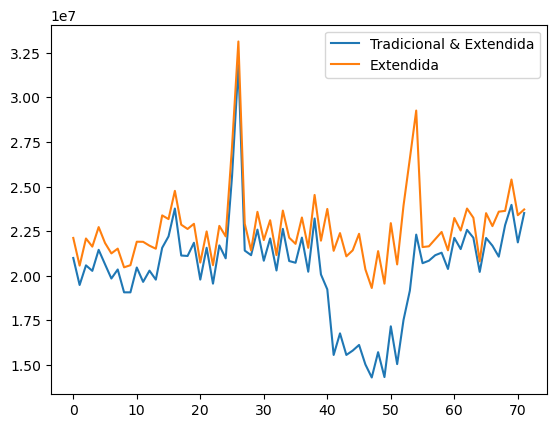

In [31]:
 aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
 ax = aux1.plot()
 aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
 aux2.plot( ax=ax )
 ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H6. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.


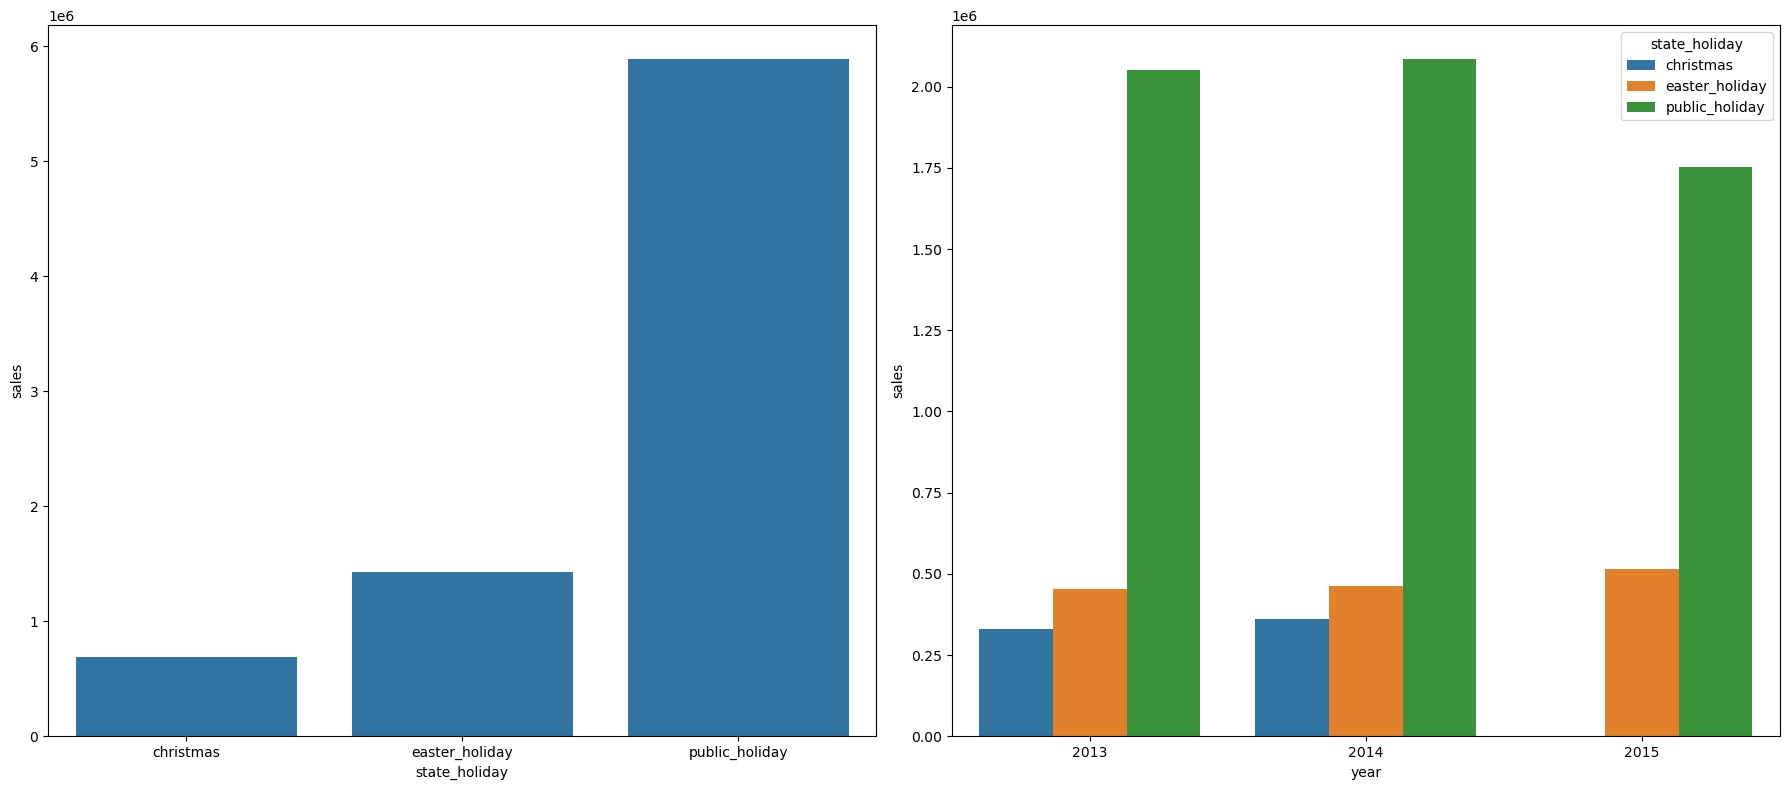

In [32]:
plt.figure(figsize=(18, 8)) 
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
plt.tight_layout()
plt.show()   

###  H7. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos


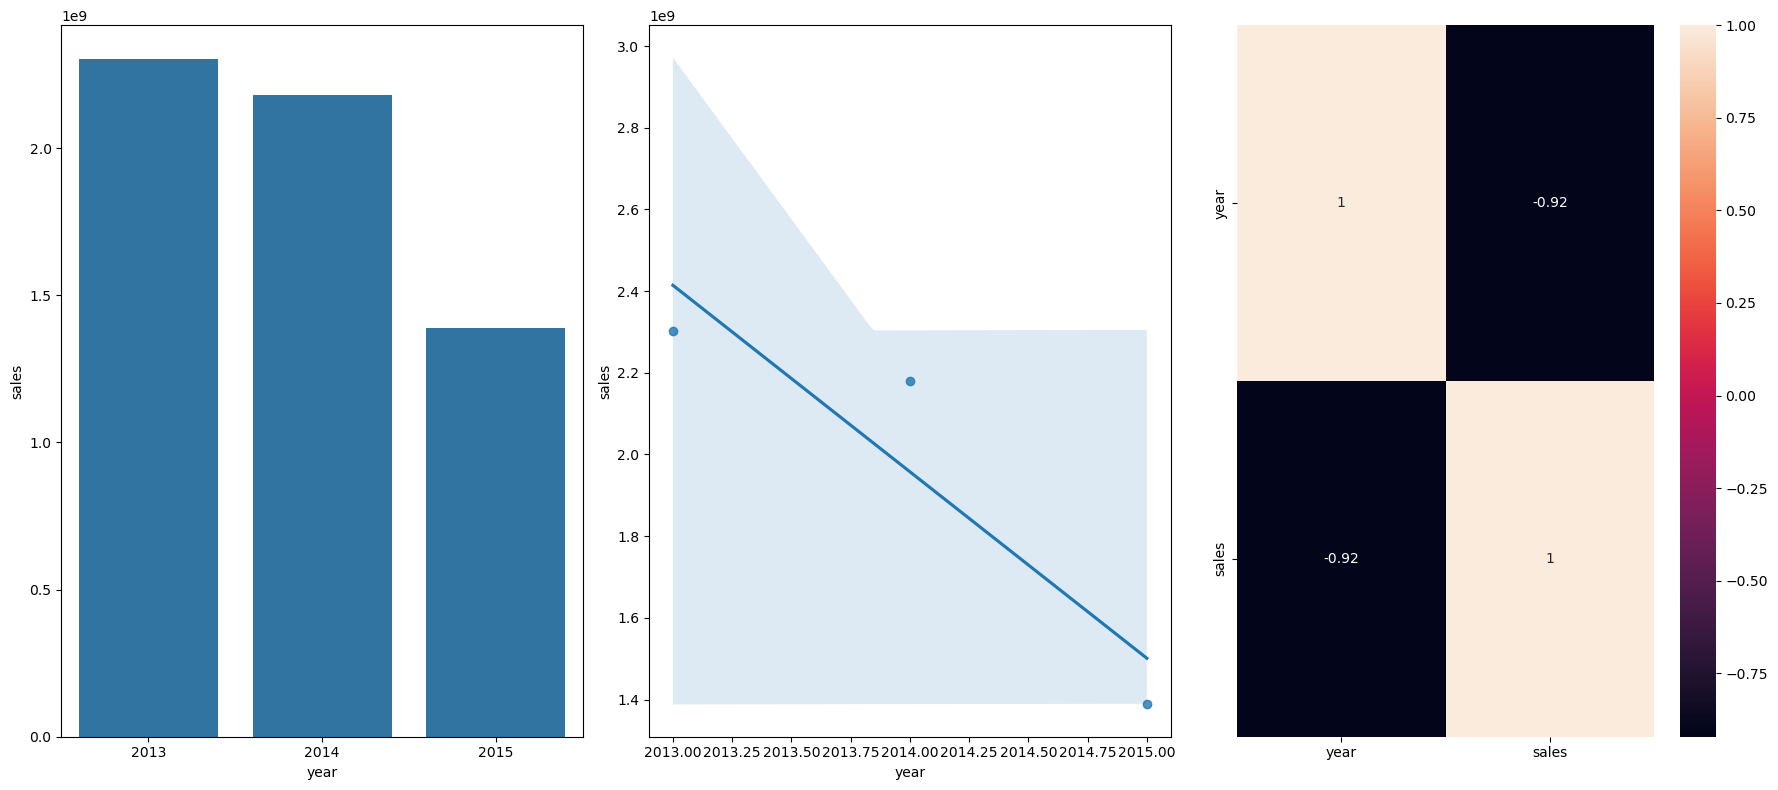

In [33]:
plt.figure(figsize=(18, 8)) 
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.tight_layout()
plt.show()   

### H8. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano


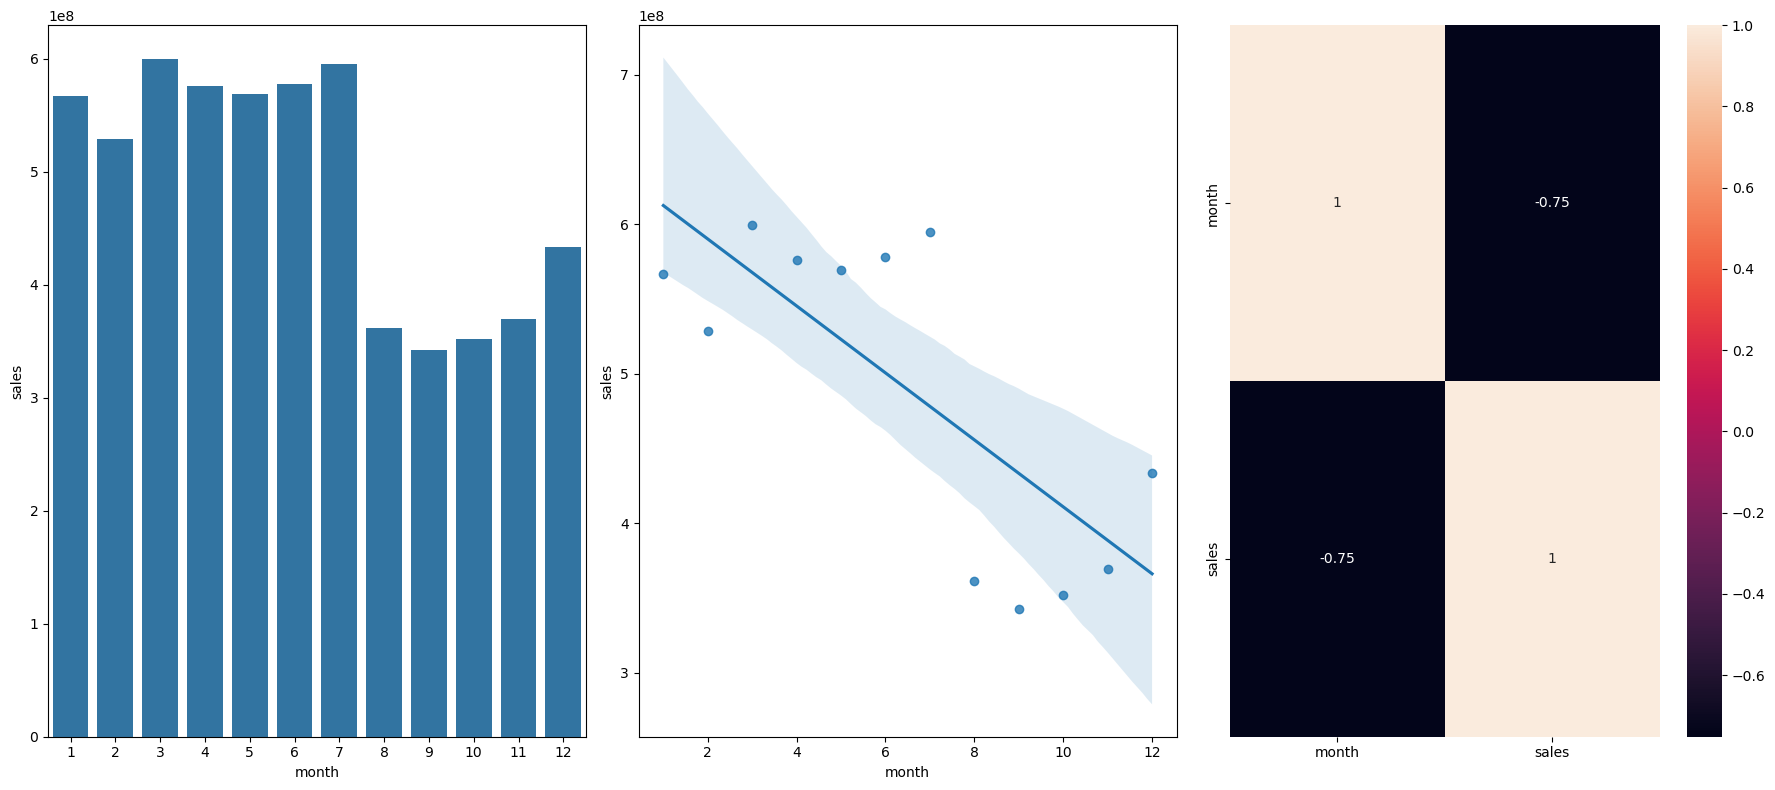

In [34]:
plt.figure(figsize=(18, 8)) 

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.tight_layout()
plt.show() 

### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.


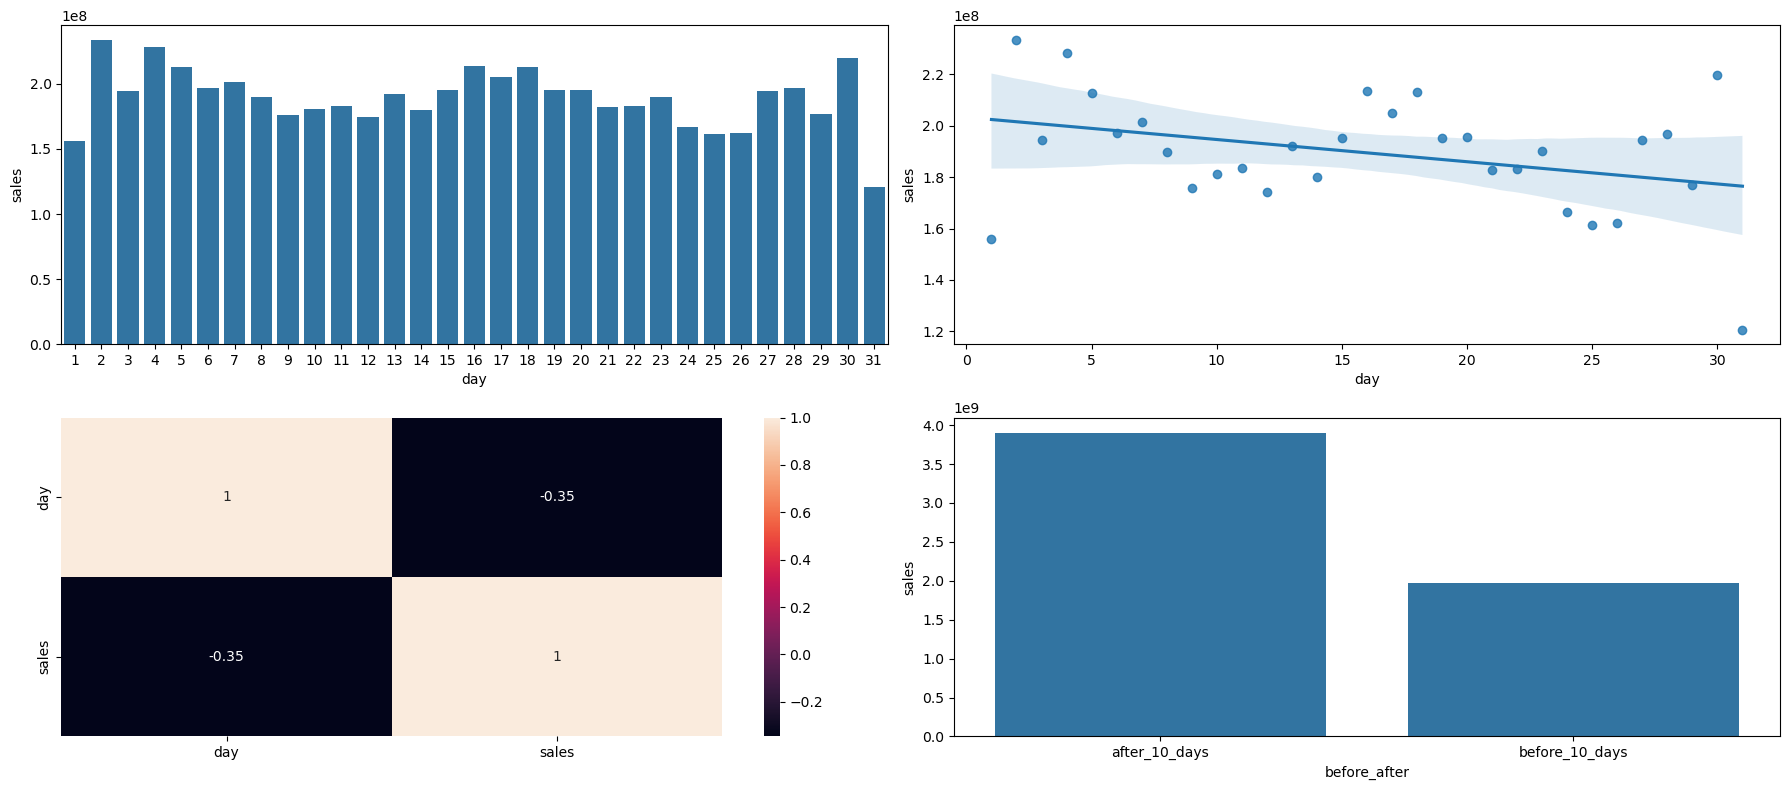

In [35]:
plt.figure(figsize=(18, 8)) 

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.tight_layout()
plt.show() 

### H10. Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem menos nos final de semana


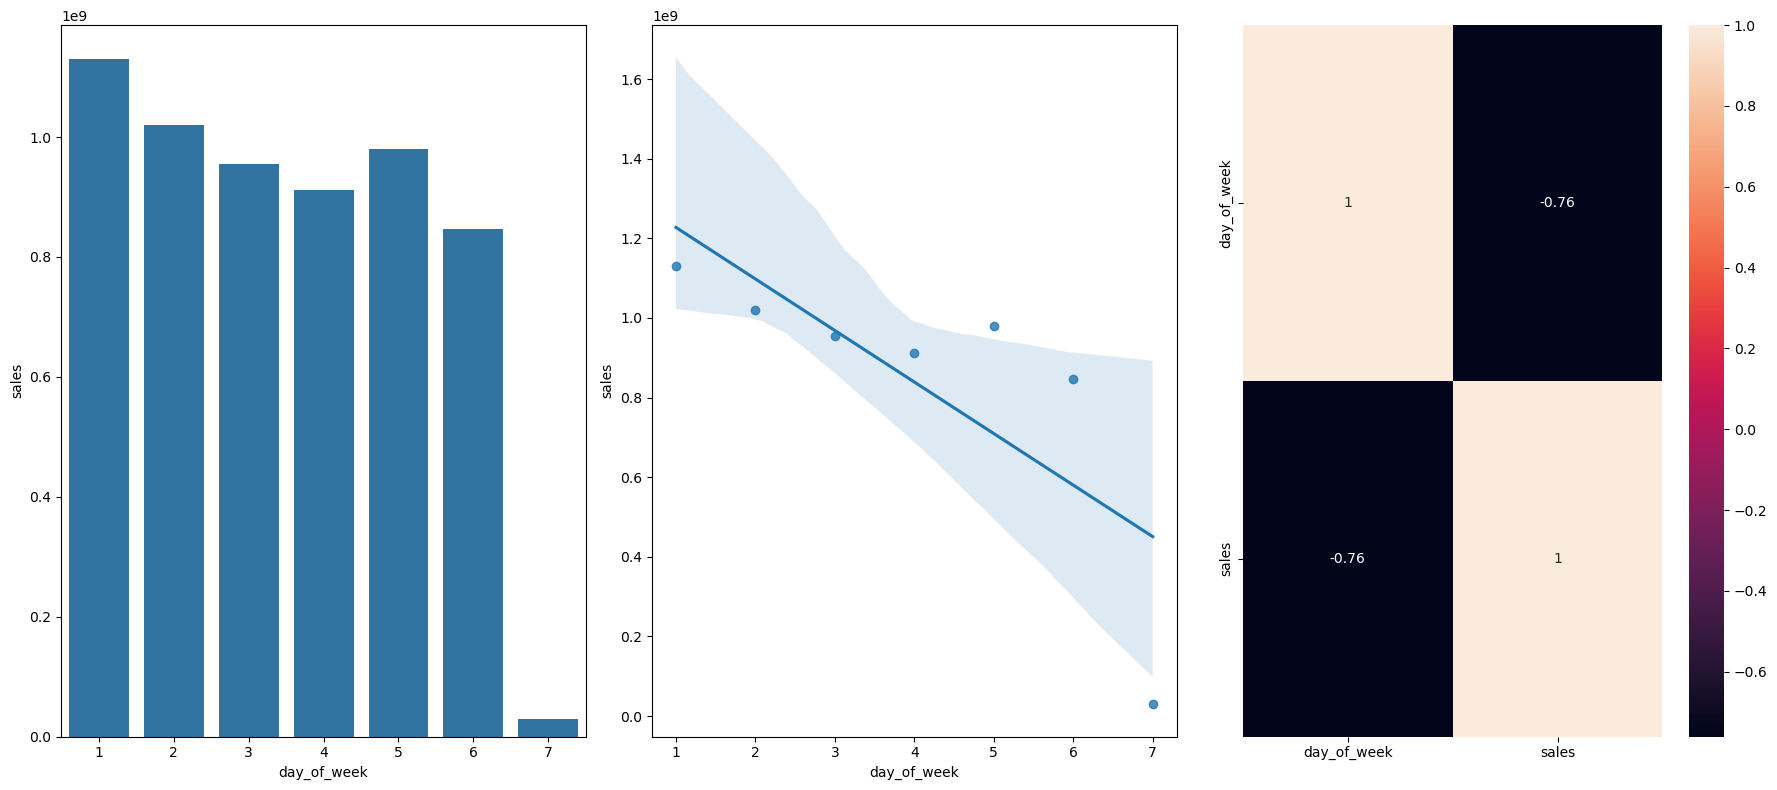

In [36]:
plt.figure(figsize=(18, 8)) 

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


plt.tight_layout()
plt.show() 

### H11. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e  Agosto.

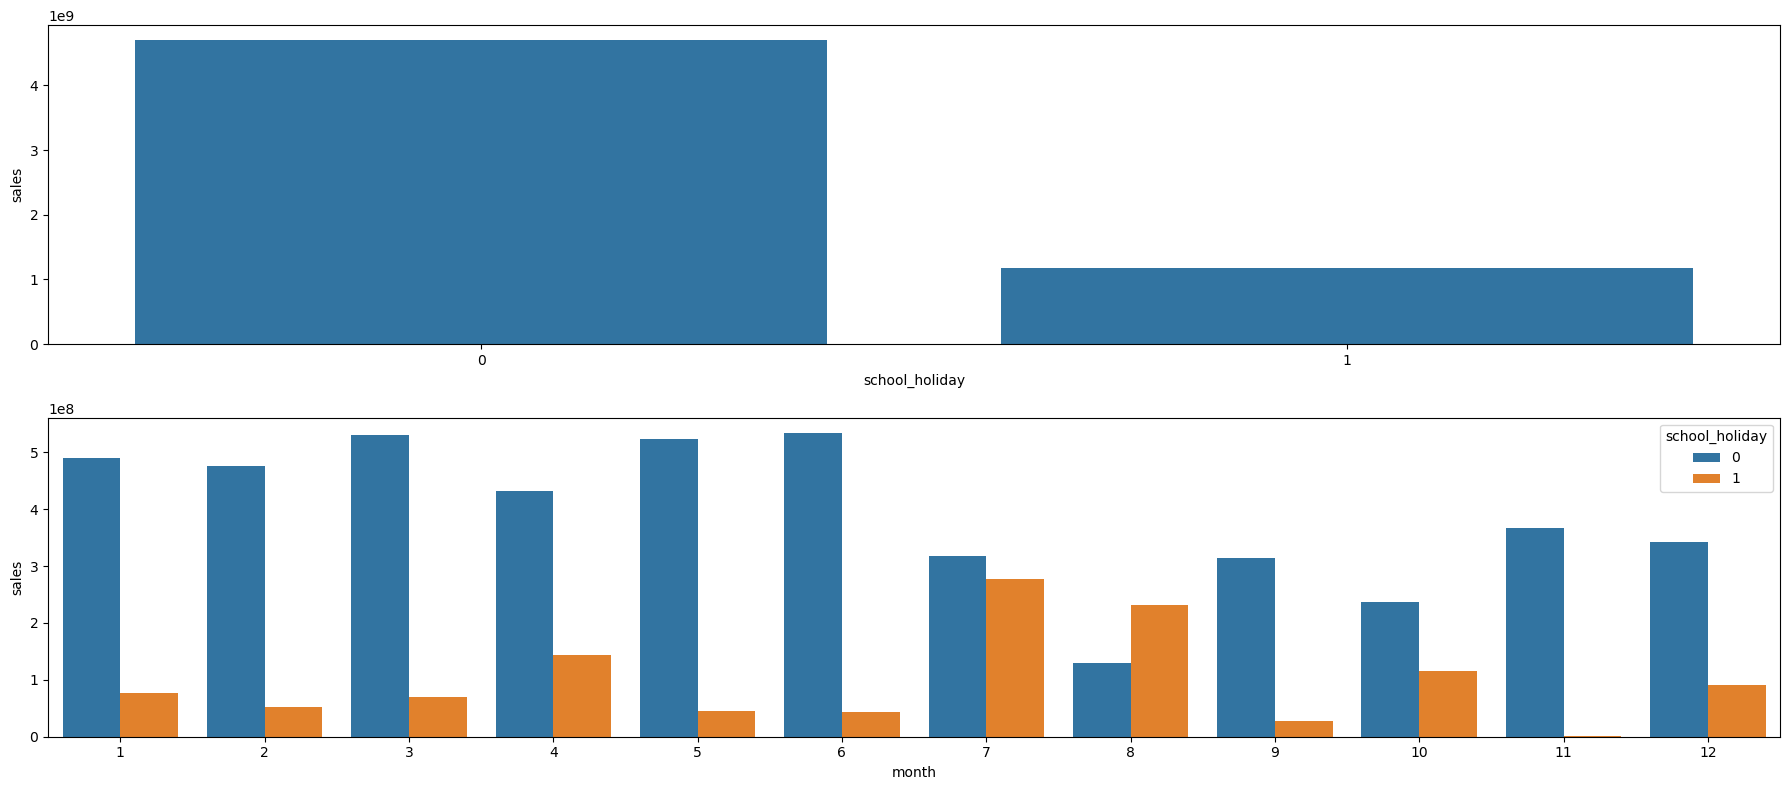

In [37]:
plt.figure(figsize=(18, 8)) 

aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

plt.tight_layout()
plt.show() 

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

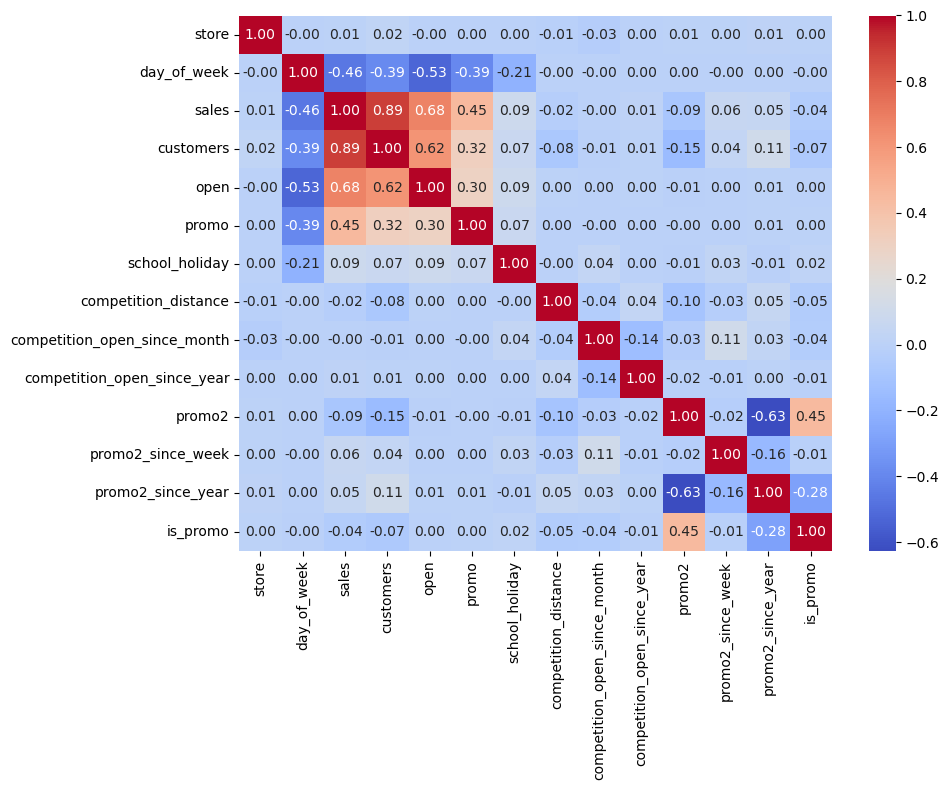

In [38]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(10, 8))  # ajusta largura e altura do gráfico
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")

plt.tight_layout()  # organiza espaçamentos
plt.show()

### 4.3.2. Categorical Attributes

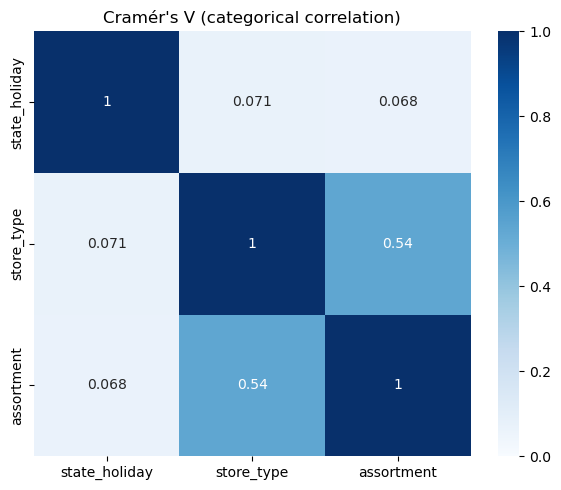

In [39]:
# only categorical data
a = df4.select_dtypes(include='object')

# Cálculo manual
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])
a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Montar matriz de correlação categórica
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type':    [a4, a5, a6],
    'assortment':    [a7, a8, a9]
}, index=['state_holiday', 'store_type', 'assortment'])

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(d, annot=True, cmap="Blues", vmin=0, vmax=1)
plt.title("Cramér's V (categorical correlation)")
plt.tight_layout()
plt.show()

# 5.0  DATA PREPARATION

In [40]:
df5 = df4.copy()

##  5.1. Normalizacao
Olhando a Análise Univariada em numerico variable, não teve distruibição normal

##  5.2. Rescaling (ajustar números para ficarem comparáveis.)

In [41]:
# caminho absoluto da pasta
path = r"C:\Users\Felipe\Documents\Repos\DS\parameter"

# competition distance
rs_competition_distance = RobustScaler()
df5['competition_distance'] = rs_competition_distance.fit_transform(df5[['competition_distance']])
pickle.dump(rs_competition_distance, open(os.path.join(path, 'competition_distance_scaler.pkl'), 'wb'))

# competition time month
rs_competition_time_month = RobustScaler()
df5['competition_time_month'] = rs_competition_time_month.fit_transform(df5[['competition_time_month']])
pickle.dump(rs_competition_time_month, open(os.path.join(path, 'competition_time_month_scaler.pkl'), 'wb'))

# promo time week
mms_promo_time_week = MinMaxScaler()
df5['promo_time_week'] = mms_promo_time_week.fit_transform(df5[['promo_time_week']])
pickle.dump(mms_promo_time_week, open(os.path.join(path, 'promo_time_week_scaler.pkl'), 'wb'))

# year
mms_year = MinMaxScaler()
df5['year'] = mms_year.fit_transform(df5[['year']])
pickle.dump(mms_year, open(os.path.join(path, 'year_scaler.pkl'), 'wb'))


# STORE TYPE 
le_store_type = LabelEncoder()
df5['store_type'] = le_store_type.fit_transform(df5['store_type'])
pickle.dump(le_store_type, open(os.path.join(path, 'store_type_scaler.pkl'), 'wb'))

##  5.3. Transformacao

### 5.3.1. Encoding (converte categorias em números para o modelo entender.)

In [42]:
# state_holiday - One Hot Encoding
# transformar cada categoria em uma coluna binária (0 ou 1).
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
# transformor cada letra (a, b, c, d) em um número inteiro (0, 1, 2, 3).
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )


# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

###  5.3.2. Transformação da Variável Resposta

In [43]:
# cria uma distribuição assimétrica 
# O log “comprime” valores grandes e deixa a distribuição mais próxima de uma normal.

df5['sales'] = np.log1p( df5['sales'] )


###  5.3.3. Nature Transformation (Transformação Cíclica)

In [44]:
# Usar o seno e cosseno para transformar cada valor em duas dimensões, que preservam a ciclicidade.

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


# 6.0  FEATURE SELECTION

In [45]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [46]:
# remover colunas que não ajudam (ou até atrapalham)

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [47]:
# training dataset
# Separa os dados em treino e teste usando a data (2015-06-19) como corte
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']

# Define a variável alvo
y_test = X_test['sales']
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [48]:
## training and test dataset for Boruta

# remove colunas que não devem ser usadas como features
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()


## definir RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )


## definir Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( ֒→X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [49]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [50]:
 cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']
 # columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )    

#  7.0 MACHINE LEARNING MODELLING

In [51]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

##  7.1. Average Model


In [52]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']
# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model


In [53]:
# model
#lr = LinearRegression().fit( x_train, y_train )
# prediction
#yhat_lr = lr.predict( x_test )
# performance
#lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
#lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [54]:
#lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
#lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [55]:
# model
#lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )
# prediction
#yhat_lrr = lrr.predict( x_test )
# performance
#lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
#lrr_result


### 7.3.1. Lasso - Cross Validation

In [56]:
#lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
#lrr_result_cv

## 7.4. Random Forest Regressor

In [57]:
# model
#rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# prediction
#yhat_rf = rf.predict( x_test )
# performance
#rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
#rf_result

## 7.4.1. Random Forest Regressor - Cross Validation

In [58]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
#rf_result_cv


## 7.5. XGBoost Regressor

In [59]:
# model
model_xgb = xgb.XGBRegressor(
   objective='reg:squarederror',
    n_estimators=100,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1684.111278,0.250161,2461.487549


### XGBoost Regressor - Cross Validation

In [60]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#xgb_result_cv

### 7.6. Compare Model’s Performance

In [61]:
#modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
#modelling_result.sort_values( 'RMSE' )

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [62]:
#param = {
#         'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]
#         }

#MAX_EVAL = 5

In [63]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)

    # model
#    model_xgb = xgb.XGBRegressor(
#        objective='reg:squarederror',
#        n_estimators=hp['n_estimators'],
#        eta=hp['eta'],
#        max_depth=hp['max_depth'],
#        subsample=hp['subsample'],
#        colsample_bytree=hp['colsample_bytree'],   # <-- cuidado, antes tinha "colsample_bytee"
#        min_child_weight=hp['min_child_weight']
#    )

# performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

## 8.2. Final Model

In [64]:
param_tuned = {
        'n_estimators': 3000,
        'eta': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3
            }


In [65]:
# model
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight']
).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,780.390273,0.116478,1131.421644


In [66]:
import pickle
import os

# caminho da pasta
path = r"C:\Users\Felipe\Documents\Repos\DS"

os.makedirs(path, exist_ok=True)

# salva o modelo
pickle.dump(model_xgb_tuned, open(os.path.join(path, "model_rossmann.pkl"), 'wb'))

# 9.0 TRADUCAO E INTERPRETACAO DO ERRO


In [67]:
df9 = X_test[cols_selected_boruta_full].copy()
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

##  9.1. Business Performance

In [68]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})
# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]


In [69]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106045.710938,102657.756952,109433.664923,3387.953986,0.591705
908,909,218489.500000,210487.244247,226491.755753,8002.255753,0.524616
594,595,324210.156250,318669.538931,329750.773569,5540.617319,0.381925
901,902,199082.937500,197699.831028,200466.043972,1383.106472,0.345605
875,876,193465.546875,189340.269552,197590.824198,4125.277323,0.327453


sns.scatterplot( x='store', y='MAPE', data=df92 )


## 9.2. Total Performance    

In [70]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:
'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,340,704.00"
1,worst_scenario,"R$284,467,484.57"
2,best_scenario,"R$286,213,946.74"


## Machine Learning Performance

In [71]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

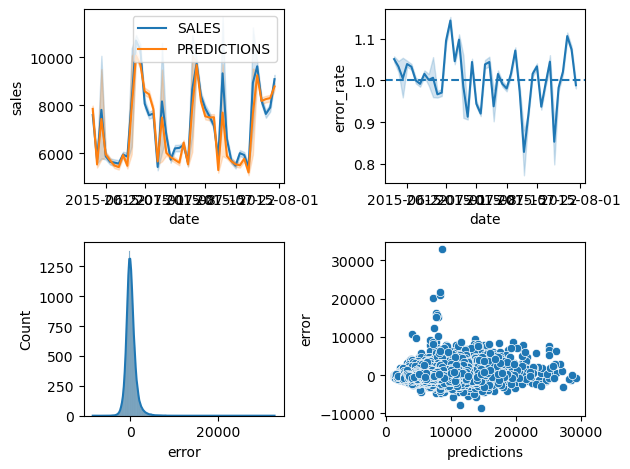

In [72]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'], kde=True)  # substitui distplot

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9)

plt.tight_layout()
plt.show()
